In [31]:
# Load dataset
file_path = 'sentiment_analysis.parquet'
df = pd.read_parquet(file_path, columns=['standardized_text'])  # Load only necessary columns
data_sample = preprocess_text(df, 'standardized_text')  # Preprocess and sample
tokenized_texts = data_sample['standardized_text'].tolist()  # Tokenized texts


In [37]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Step 1: Create Dictionary and Corpus
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=10, no_above=0.4)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Step 2: Train LDA Model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# Step 3: Extract Topics Safely
lda_topics = []
for i in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(i, topn=10)  # List of (term, weight)
    lda_topics.append([term for term, _ in topic_terms])  # Extract terms only

print("LDA Topics:")
for idx, topic in enumerate(lda_topics):
    print(f"Topic {idx + 1}: {', '.join(topic)}")

# Step 4: Calculate Coherence Score
def calculate_coherence(topics, tokenized_texts, dictionary, coherence_metric='c_v'):
    coherence_model = CoherenceModel(
        topics=topics, texts=tokenized_texts, dictionary=dictionary, coherence=coherence_metric
    )
    return coherence_model.get_coherence()

lda_coherence = calculate_coherence(lda_topics, tokenized_texts, dictionary)
print(f"\nLDA Coherence Score: {lda_coherence}")


LDA Topics:
Topic 1: new, th, city, says, one, mrs, w, york, center, title
Topic 2: reports, mrs, new, today, company, earnings, miss, qtr, j, mr
Topic 3: new, york, said, us, million, would, c, state, today, two
Topic 4: new, first, week, last, today, time, bill, york, game, two
Topic 5: new, says, war, years, prices, american, lead, may, yesterday, month

LDA Coherence Score: 0.39731052029522385


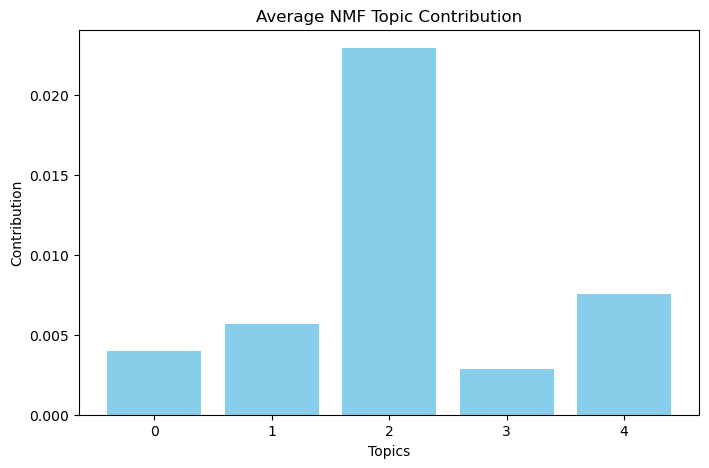

NMF Coherence Score: 0.5671143845051235
NMF Topics:
Topic 1: title, article, announcement, marriage, birth, notice, page, illus, rept, trip
Topic 2: reports, qtr, earnings, company, sept, net, june, corp, share, dec
Topic 3: new, york, today, city, week, state, said, says, president, lead
Topic 4: obituary, title, marriage, funeral, announcement, birth, bach, notice, death, grenville
Topic 5: mrs, son, mr, miss, death, married, daughter, bride, wed, jr


In [39]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=30000)
tfidf_matrix = vectorizer.fit_transform([" ".join(text) for text in tokenized_texts])

# Train NMF model
nmf_model = NMF(n_components=5, random_state=42, max_iter=200)
nmf_topics_matrix = nmf_model.fit_transform(tfidf_matrix)

# Extract topics
nmf_terms = vectorizer.get_feature_names_out()
nmf_topics = [[nmf_terms[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]

# Plot average topic contributions
average_contribution = nmf_topics_matrix.mean(axis=0)
plot_topic_distribution(average_contribution, "Average NMF Topic Contribution", "Topics", "Contribution")

# Calculate coherence
nmf_coherence = calculate_coherence(nmf_topics, tokenized_texts, dictionary)
print(f"NMF Coherence Score: {nmf_coherence}")
print("NMF Topics:")
for idx, topic in enumerate(nmf_topics):
    print(f"Topic {idx + 1}: {', '.join(topic)}")


BERTopic Topics:
    Topic  Count                                      Name  \
0      -1   1773                       -1_new_says_us_city   
1       0    584                   0_game_team_wins_league   
2       1    162                      1_court_ct_jury_case   
3       2    158                 2_bonds_bond_stock_market   
4       3    139              3_mrs_married_bride_daughter   
5       4    138                     4_book_books_pp_story   
6       5    114                5_music_concert_hall_dance   
7       6    112                 6_art_museum_fashion_show   
8       7     92           7_frank_charles_stevenson_maher   
9       8     88          8_building_apartment_street_sold   
10      9     85                   9_dies_died_death_years   
11     10     80      10_students_college_teachers_schools   
12     11     73      11_election_democratic_party_primary   
13     12     73           12_reports_earnings_qtr_company   
14     13     62          13_soviet_moscow_ussr_khrus

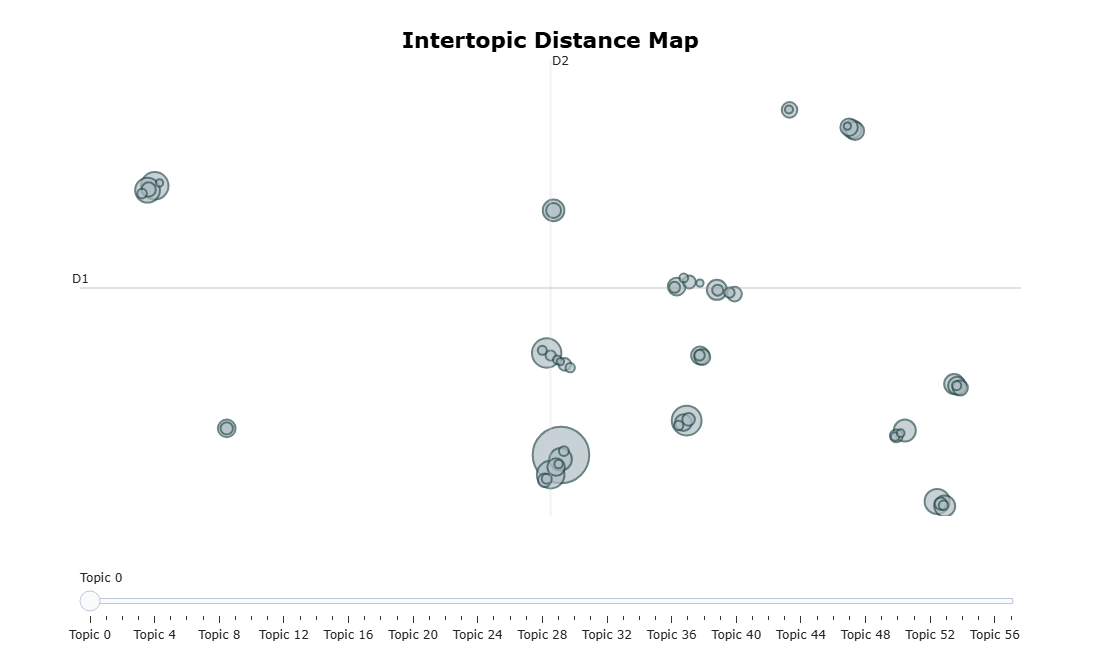

In [49]:
# BERTopic Model
preprocessed_text = [" ".join(text) for text in tokenized_texts]
bertopic_model = BERTopic()
bertopic_topics, bertopic_probs = bertopic_model.fit_transform(preprocessed_text)

# Extract topic information
topic_info = bertopic_model.get_topic_info()
print("BERTopic Topics:")
print(topic_info)

# Intertopic Distance Map
bertopic_model.visualize_topics().show()


In [51]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Extract topics from BERTopic as words
bertopic_topics = [
    [word for word, _ in bertopic_model.get_topic(topic_id)]  # Extract top words for each topic
    for topic_id in bertopic_model.get_topics().keys() if topic_id != -1  # Exclude outliers (-1)
]

# Tokenize the preprocessed text for gensim
tokenized_texts = [text.split() for text in preprocessed_text]

# Create dictionary and corpus
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Calculate coherence using gensim
coherence_model = CoherenceModel(
    topics=bertopic_topics,  # Pass words, not token IDs
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)
bertopic_coherence = coherence_model.get_coherence()

# Output coherence score
print(f"BERTopic Coherence Score: {bertopic_coherence}")


BERTopic Coherence Score: 0.46058516386098


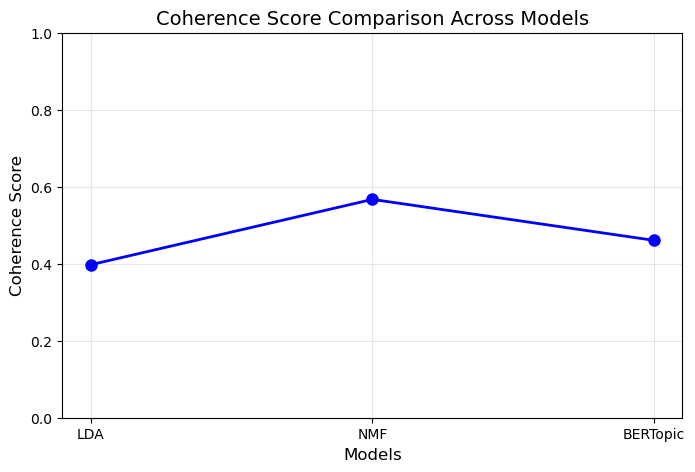

In [53]:
import matplotlib.pyplot as plt

# Assuming these coherence scores were calculated previously
lda_coherence = lda_coherence 
nmf_coherence = nmf_coherence  
bertopic_coherence = bertopic_coherence  

# Model names and corresponding coherence scores
models = ['LDA', 'NMF', 'BERTopic']
coherence_scores = [lda_coherence, nmf_coherence, bertopic_coherence]

# Plotting the coherence scores
plt.figure(figsize=(8, 5))
plt.plot(models, coherence_scores, marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
plt.title("Coherence Score Comparison Across Models", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
plt.ylim(0, 1)  # Assuming coherence scores range from 0 to 1
plt.grid(alpha=0.3)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
